## This is Dimas' Notebook

# Basic COVID-19 Detection by X-Ray Image Classification

These code mainly adapted from https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

First we import the necessary packages. For building and training models, we use **tf.keras**. We also use **scikit-learn** for data preprocessing and report. **matplotlib** used for data visualization. For data building and processing we use **os**, **imutils**, **numpy**, and **cv2**.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Import the dataset

We used dataset from public source provided by ...

In [0]:
GIT_PATH = "https://github.com/sanggusti/bangkit_assessment_1.git"
!git clone "{GIT_PATH}"
%cd ./bangkit_assessment_1
%ls
%pwd

Cloning into 'bangkit_assessment_1'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 70 (delta 4), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (70/70), done.
/content/bangkit_assessment_1
arief_notebook.ipynb  dimas_notebook.ipynb  README.md
dataset/              gusti_notebook.ipynb


'/content/bangkit_assessment_1'

### Set directory variable

In [0]:
args = {'dataset': 'dataset',
        'plot': 'plot.png',
        'model': 'covid19.model'}

### Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [0]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset")
print(imagePaths)
data = []
labels = []

[INFO] loading images...
['dataset/normal/person1599_virus_2776.jpeg', 'dataset/normal/IM-0033-0001-0001.jpeg', 'dataset/normal/person939_bacteria_2864.jpeg', 'dataset/normal/person1290_virus_2215.jpeg', 'dataset/normal/person1_bacteria_2.jpeg', 'dataset/normal/person259_bacteria_1220.jpeg', 'dataset/normal/person438_bacteria_1893.jpeg', 'dataset/normal/person1102_bacteria_3043.jpeg', 'dataset/normal/person1830_bacteria_4693.jpeg', 'dataset/normal/person339_bacteria_1574.jpeg', 'dataset/normal/person378_virus_761.jpeg', 'dataset/normal/person525_bacteria_2216.jpeg', 'dataset/normal/person934_virus_1595.jpeg', 'dataset/normal/IM-0466-0001.jpeg', 'dataset/normal/NORMAL2-IM-0315-0001.jpeg', 'dataset/normal/person989_virus_1667.jpeg', 'dataset/normal/NORMAL2-IM-0696-0001.jpeg', 'dataset/normal/person1558_bacteria_4066.jpeg', 'dataset/normal/person651_bacteria_2543.jpeg', 'dataset/normal/NORMAL2-IM-1179-0001.jpeg', 'dataset/normal/person925_virus_1582.jpeg', 'dataset/normal/person612_bacter

## Preprocess the data

### Feature and label building

Building labels and pixel data by looping over the image paths from the dataset

In [0]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

Normalization of pixel value and convert to numpy array

In [0]:
data = np.array(data) / 255.0
labels = np.array(labels)

Build one-hot encoding on the labels

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Data partition
Partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

### Training data augmentation
Initialize the training data augmentation object

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

## Build the model

### Hyperparameter tuning

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

### Load the network model

Load the VGG16 network, ensuring the head FC layer sets are left off

In [0]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 1s 0us/step


Construct the head of the model that will be placed on top of the the base model

In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

Place the head FC model on top of the base model (this will become the actual model we will train)

In [0]:
model = Model(inputs=baseModel.input, outputs=headModel)

Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [0]:
for layer in baseModel.layers:
	layer.trainable = False

### Compile the model

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## Train the model

### Train the head of the network

In [0]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 22s 4s/step - loss: 0.8170 - accuracy: 0.4500 - val_loss: 0.7281 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 21s 4s/step - loss: 0.6994 - accuracy: 0.6250 - val_loss: 0.6859 - val_accuracy: 0.6000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.7823 - accuracy: 0.4750 - val_loss: 0.6696 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 21s 4s/step - loss: 0.6955 - accuracy: 0.5500 - val_loss: 0.6471 - val_accuracy: 0.7000
Epoch 5/25
5/5 [==============================] - 21s 4s/step - loss: 0.5637 - accuracy: 0.7000 - val_loss: 0.6318 - val_accuracy: 0.6000
Epoch 6/25
5/5 [==============================] - 21s 4s/step - loss: 0.6225 - accuracy: 0.6000 - val_loss: 0.6208 - val_accuracy: 0.6000
Epoch 7/25
5/5 [==============================] - 21s 4s/step - loss: 0.

### Make predictions on the testing set

In [0]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


### For each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [0]:
predIdxs = np.argmax(predIdxs, axis=1)

### Show a nicely formatted classification report

In [0]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.40      0.57         5
      normal       0.62      1.00      0.77         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



### Compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity

In [0]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

### Show the confusion matrix, accuracy, sensitivity, and specificity

In [0]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[2 3]
 [0 5]]
acc: 0.7000
sensitivity: 0.4000
specificity: 1.0000


### Plot the training loss and accuracy

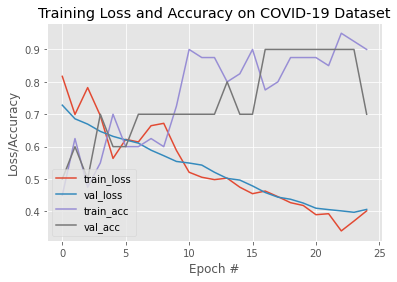

In [0]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

### Serialize the model to disk

In [0]:
print("[INFO] saving COVID-19 detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving COVID-19 detector model...


In [0]:
%ls

arief_notebook.ipynb  dataset/              gusti_notebook.ipynb  README.md
covid19.model         dimas_notebook.ipynb  plot.png
